## Exploratory Plots of Digg Data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# load in data
# votes = np.load("digg_votes.npy")
# friends = np.load("digg_friends.npy")

In [2]:
# extract all network information (compact dataframe of who is friends with whom)
# from https://github.com/geopanag/IMINFECTOR/blob/master/digg_preprocessing.py
def extract_network(file):
    friends = pd.read_csv(file,header=None)
    
    #--------- Remove self friendships
    friends = friends[friends[2]!=friends[3]]
    
    #--------- Repeat the reciprocal edges and append them
    reciprocal = friends[friends[0]==1]
    friends = friends.drop(0,1)
    reciprocal = reciprocal.drop(0,1)
    
    #---- Create the reciprocal edge for each pair
    tmp = reciprocal[2].copy()
    reciprocal[2] = reciprocal[3]
    reciprocal[3] = tmp

    #--------- Find the edges that already exist in the dataset as reciprocal, and remove them, 
    #--------- to avoid overwriting the currect time of the reciprocal edges that already exist
    to_remove = reciprocal.reset_index().merge(friends,left_on=[2,3],right_on=[2,3]).set_index('index').index
    reciprocal = reciprocal.drop(to_remove)
    
    friends = friends.append(reciprocal)
    friends[friends.duplicated([2,3],keep=False)] #-- this should be empty

    #----------- Store the weighted follow network
    friends.columns = ["time","a","b"]
    friends = friends[["a","b","time"]]
    return friends
#     friends.to_csv("../digg_network.txt",index=False,sep=" ",header=False)


# def extract_cascades(file):
#     #----------- Derive and store the train and test cascades
#     votes = pd.read_csv(file,header=None)
#     votes.columns = ["time","user","post"]
#     votes = votes.sort_values(by=["time"])
    
#     #---- Find the threshold after which the cascades are test cascades (final 20% of cascades)
#     start_times = votes.groupby("post")["time"].min() #--- take into consideration only the starting time of each cascade
#     start_times = start_times.sort_values()
#     no_test_cascades = round(20*len(start_times)/100)
#     threshold = min(start_times.tail(no_test_cascades))
#     #sum(start_times<threshold )/start_times.shape[0]
    
#     f_train = open("train_cascades.txt","w")
#     f_test = open("test_cascades.txt","w")

#     #--------- For each cascade
#     for i in votes["post"].unique():
#         print(i)
#         sub = votes[votes["post"]==i]
#         s = ""
    
#         #---- id:time, id:time etc...
#         for post in sub.sort_values(by=['time']).iterrows():
#             s = s+str(post[1]["user"])+" "+str(post[1]["time"])+";"#":"+str(post[1]["time"])+","
#         s = s[:-1]
    
#         #---- Check if it has started before or after the threshold
#         if(min(sub["time"])<threshold):
#             f_train.write(s+"\n")
#         else:
#             f_test.write(s+"\n")
#     f_train.close()
#     f_test.close()

In [3]:
file_friends = "digg2009/digg_friends.csv"
file_votes = "digg2009/digg_votes.csv"

friendships_df = extract_network(file_friends)
friendships_df = friendships_df.rename(columns={'a': 'source', 'b': 'target', 'time':'time'})

friendships_df.describe()
# friendships_df.to_csv("digg2009/digg_friends_preprocessed.csv", index=False)
# digg_extract_cascades(file_casc)

In [59]:
friendship_plot_df = friendships_df[['source', 'target']]
friendship_plot_smol = friendship_plot_df.head(150)
friendship_plot_smol.head()

,source,target
0,336224,266641
1,336224,215086
2,336224,151094
3,336224,59378
4,336224,8547


/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


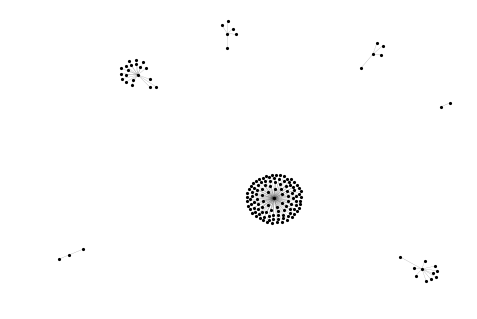

In [5]:
# plot of directed graph showing all friendships (currently taking a random sample due to size issues)
G = nx.convert_matrix.from_pandas_edgelist(friendship_plot_smol)
options = {
    "node_color": "black",
    "node_size": 10,
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, **options)
plt.show()

###### currently, scability of networkx is an issue; look into https://graph-tool.skewed.de/ if we want to graph more points

## Plot of social network graph for one story

In [60]:
votes = pd.read_csv(file_votes,header=None)
votes.columns = ['time','user','post']
votes = votes.sort_values(by=["time"])
votes.describe()

,time,user,post
count,3.018197e+06,3.018197e+06,3.018197e+06
mean,1.245300e+09,1.662883e+05,1.767381e+03
std,7.750953e+05,9.842756e+04,1.012042e+03
min,1.243770e+09,2.000000e+00,1.000000e+00
25%,1.244635e+09,7.905100e+04,8.560000e+02
50%,1.245307e+09,1.660930e+05,1.774000e+03
75%,1.245961e+09,2.515810e+05,2.666000e+03
max,1.246793e+09,3.362240e+05,3.553000e+03


In [98]:
# the most popular story is story xxx?
story = 80

votes_story = votes.loc[votes['post'] == story]
votes_story = votes_story.drop(['post'], axis=1)
tmp = votes_story.copy()
votes_story.describe()

,time,user
count,2.950000e+02,295.00000
mean,1.246517e+09,164913.39322
std,3.378470e+04,102389.33090
min,1.246476e+09,122.00000
25%,1.246503e+09,72438.50000
50%,1.246507e+09,161153.00000
75%,1.246531e+09,258517.00000
max,1.246699e+09,335807.00000


In [99]:
# cross join to get all edges in network graph
votes_story['key'] = 0
tmp['key'] = 0
merged = votes_story.merge(tmp, how='outer', on='key')
merged = merged.drop(columns=['key'])
merged = merged.loc[merged['time_x'] < merged['time_y']]
merged = merged.drop(['time_x', 'time_y'], axis=1)
merged.columns = ['source', 'target']
merged.head()
# merged.describe()

,source,target
1,57299,324632
2,57299,263856
3,57299,108217
4,57299,187459
5,57299,16255


In [102]:
# keep rows that are in friends_preprocessed df
merged_plot = friendship_plot_df.merge(merged, on=['source', 'target'], how='inner')
merged_plot.head()

,source,target
0,332346,310482
1,332346,310354
2,332346,307201
3,332346,292258
4,332346,291369


In [103]:
# define edges of social network graph by adding entries of adjacent users
# votes_story = pd.concat([votes_story, votes_story[['user']].shift(-1)], axis=1, ignore_index=True)
# votes_story.drop(votes_story.tail(1).index,inplace=True)
# votes_story.columns = ['source', 'target']
# votes_story.head()

/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


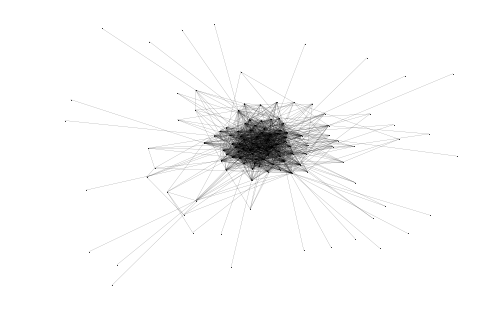

In [104]:
# plot social network graph for one story
G = nx.convert_matrix.from_pandas_edgelist(merged_plot)
options = {
    "node_color": "black",
    "node_size": 1,
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, **options)
# plt.show()

## Distance Calculations

In [280]:
friendship_plot_df.head()

,source,target
0,336224,266641
1,336224,215086
2,336224,151094
3,336224,59378
4,336224,8547


In [281]:
# the most popular story is story xxx?
story = 714

votes_story = votes.loc[votes['post'] == story]
votes_714 = votes_story.copy()

# define source
source = votes_story.iloc[0]['user']
votes_story = votes_story.iloc[1:]  # drop source
print(source)
votes_story.head()

332346


,time,user,post
635382,1245966217,266353,714
633072,1245966220,234047,714
617426,1245966232,16255,714
631543,1245966242,212449,714
633006,1245966253,233093,714


In [282]:
friends_of_source = friendship_plot_df.loc[friendship_plot_df['source'] == source]
friends_of_source.head()

,source,target
21178,332346,335404
21179,332346,330931
21180,332346,330732
21181,332346,330619
21182,332346,330082


In [283]:
# find distance 1 voters
dist_1_users = votes_story.loc[votes_story['user'].isin(friends_of_source['target'])]
dist_1_users = dist_1_users['user'].tolist()

votes_story = votes_story.loc[~votes_story['user'].isin(dist_1_users)]
votes_story.head()

,time,user,post
635382,1245966217,266353,714
630547,1245966264,199866,714
622391,1245966280,83538,714
634547,1245966288,254792,714
635925,1245966295,274161,714


In [284]:
# all friend at distance 2 (regardless of whether they voted)
dist_2_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(friends_of_source['target'])]
dist_2_friends = friends['target'].tolist()

# find distance 2 voters
dist_2_users = votes_story.loc[votes_story['user'].isin(dist_2_friends)]
dist_2_users = dist_2_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_2_users)]
dist_2_users

[266353,
 57284,
 94387,
 213094,
 133378,
 89671,
 257373,
 314190,
 8818,
 134789,
 188222,
 300630,
 46250,
 94615,
 147375,
 50137,
 34128,
 291365,
 148786,
 284195,
 280812,
 56297,
 146748,
 314203,
 186825,
 209309,
 273844,
 40242,
 126976,
 291850,
 307948,
 145703,
 90439,
 191175,
 51900,
 226301,
 273761,
 299620,
 276087,
 280678,
 276061,
 100611,
 85563,
 24937,
 30860,
 331661,
 296942,
 116631,
 240900,
 41736,
 102431,
 196120,
 100561,
 238764,
 259015,
 93942,
 63501,
 176328,
 213817,
 108240,
 200712,
 45732,
 226291,
 298825,
 52409,
 4805,
 68262,
 196688,
 107542,
 227347,
 221211,
 330235,
 191503,
 117528,
 158320,
 271747,
 236202,
 71050,
 263398,
 84951,
 62560,
 58324,
 229933,
 333984,
 132740,
 8288,
 87789,
 116838,
 282568,
 217559,
 10699,
 145991,
 254347,
 292663,
 201366,
 274336,
 317156,
 298705,
 307913,
 261677,
 159514,
 57166,
 65524,
 44158,
 67659,
 7222,
 272488,
 314628,
 214833,
 135890,
 67575,
 212326,
 319963,
 87155,
 297234,
 7729

In [285]:
# all friend at distance 3 (regardless of whether they voted)
dist_3_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_2_friends)]
dist_3_friends = friends['target'].tolist()

# find distance 3 voters
dist_3_users = votes_story.loc[votes_story['user'].isin(dist_3_friends)]
dist_3_users = dist_3_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_3_users)]
dist_3_users

[83538,
 254792,
 274161,
 119685,
 283749,
 307327,
 78715,
 155138,
 283714,
 212945,
 82483,
 325823,
 256185,
 204556,
 215489,
 322700,
 76782,
 277316,
 278835,
 274969,
 53944,
 32158,
 264171,
 264158,
 52615,
 67371,
 66341,
 285204,
 13731,
 220739,
 292089,
 176805,
 227097,
 150202,
 320853,
 133027,
 250315,
 299210,
 97562,
 120397,
 246247,
 151722,
 321338,
 48639,
 123927,
 67573,
 303929,
 258148,
 152009,
 53702,
 189001,
 60807,
 42190,
 205671,
 24271,
 331325,
 24359,
 148318,
 185935,
 49322,
 26092,
 210473,
 141622,
 297464,
 291384,
 246039,
 269989,
 40822,
 251407,
 40843,
 7275,
 218376,
 243110,
 324202,
 224045,
 229781,
 74538,
 27071,
 55034,
 136099,
 110362,
 252233,
 157711,
 290760,
 239943,
 195071,
 148295,
 77293,
 315853,
 214630,
 205729,
 147786,
 77680,
 240668,
 142598,
 92880,
 214000,
 7230,
 121308,
 239336,
 114376,
 306222,
 19483,
 169867,
 8155,
 238280,
 77147,
 127706,
 202830,
 128582,
 123286,
 2522,
 295130,
 43089,
 26045,
 1882

In [286]:
# all friend at distance 4 (regardless of whether they voted)
dist_4_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_3_friends)]
dist_4_friends = friends['target'].tolist()

# find distance 4 voters
dist_4_users = votes_story.loc[votes_story['user'].isin(dist_4_friends)]
dist_4_users = dist_4_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_4_users)]
dist_4_users

[199866,
 35173,
 90896,
 17451,
 274304,
 165466,
 206564,
 46653,
 26780,
 14525,
 192636,
 84817,
 209088,
 130091,
 19469,
 214423,
 34656,
 166037,
 15405,
 112189,
 171648,
 298155,
 23780,
 256937,
 295378,
 159780,
 61066,
 159923,
 329123,
 266078,
 234762,
 118603,
 94761,
 151568,
 240312,
 284602,
 5711,
 236552,
 160893,
 332994,
 1901,
 107953,
 169399,
 314544,
 1463,
 203388,
 55224,
 265988,
 64534,
 273706,
 210922,
 13357,
 236897,
 105856,
 86274,
 219524,
 293006,
 65859,
 20574,
 40441,
 4241,
 162421,
 37744,
 127563,
 292783,
 211526,
 139511,
 113755,
 227328,
 26513,
 197006,
 296266,
 128326,
 280883,
 217375,
 99427,
 329289,
 275624,
 269896,
 10593,
 158163,
 61080,
 228871,
 149487,
 142495,
 293364,
 105659,
 229081,
 323789,
 216702,
 164046,
 99901,
 275079,
 67442,
 156231,
 126036,
 210035,
 4406,
 9819,
 122893,
 300455,
 310271,
 321547,
 294448,
 197724,
 246471,
 149626,
 105570,
 200446,
 276153,
 213974,
 257525,
 17596,
 129642,
 171024,
 5200

In [287]:
# all friend at distance 5 (regardless of whether they voted)
dist_5_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_4_friends)]
dist_5_friends = friends['target'].tolist()

# find distance 5 voters
dist_5_users = votes_story.loc[votes_story['user'].isin(dist_5_friends)]
dist_5_users = dist_5_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_5_users)]
dist_5_users

[185098,
 193893,
 267527,
 14523,
 227636,
 248309,
 33701,
 267248,
 3331,
 159682,
 135437,
 277061,
 289949,
 73219,
 8323,
 89056,
 122217,
 188815,
 90521,
 843,
 74789,
 32053,
 200508,
 93982,
 23766,
 182888,
 230047,
 139805,
 260953,
 331839,
 170400,
 103262,
 88840,
 247890,
 120921,
 23192,
 46731,
 134198,
 151875,
 188085,
 25941,
 305967,
 161852,
 55462,
 333223,
 98626,
 236222,
 121419,
 86146,
 52383,
 192862,
 71189,
 42252,
 291975,
 136958,
 101807,
 155773,
 11105,
 296062,
 4941,
 203799,
 18931,
 184614,
 30293,
 134724,
 119641,
 145002,
 142646,
 280277,
 203633,
 17095,
 29430,
 152295,
 150253,
 56483,
 286913,
 100842,
 58929,
 88974,
 72289,
 231644,
 161761,
 119878,
 54546,
 106918,
 109516,
 287304,
 298991,
 63195,
 204192,
 70322,
 158078,
 125791,
 64486,
 205053,
 114738,
 160920,
 62339,
 87054,
 259709,
 135272,
 174260,
 230367,
 137205,
 210345,
 162577,
 314362,
 210890,
 59825,
 296106,
 9565,
 267715,
 310453,
 267167,
 153569,
 263041,
 2

In [288]:
# all friend at distance 6 (regardless of whether they voted)
dist_6_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_5_friends)]
dist_6_friends = friends['target'].tolist()

# find distance 6 voters
dist_6_users = votes_story.loc[votes_story['user'].isin(dist_6_friends)]
dist_6_users = dist_6_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_6_users)]
dist_6_users

[48147,
 54452,
 58126,
 106607,
 133170,
 147068,
 251103,
 296660,
 154769,
 192625,
 84678,
 163342,
 141865,
 189924,
 249497,
 195202,
 196350,
 134212,
 10713,
 19456,
 229822,
 280473,
 70347,
 247000,
 102338,
 304628,
 66419,
 60081,
 24112,
 281159,
 20232,
 59686,
 252317,
 308203,
 110214,
 249446,
 321078,
 255130,
 252436,
 118259,
 274793,
 213387,
 114770,
 326987,
 17024,
 169093,
 313892,
 137778,
 19344,
 41661,
 53117,
 8418,
 284896,
 187710,
 105751,
 295622,
 159722,
 298226,
 224363,
 165121,
 292253,
 316183,
 321342,
 164152,
 301872,
 306421,
 332472,
 187518,
 329282,
 190080,
 90748,
 183500,
 20000,
 216313,
 252287,
 284541,
 136611,
 206238,
 140325,
 158888,
 11662,
 219539,
 240851,
 307826,
 152793,
 256422,
 92812,
 298001,
 281850,
 184718,
 292159,
 172827,
 212286,
 53589,
 126426,
 150835,
 305680,
 189858,
 122521,
 99986,
 60778,
 134634,
 119598,
 321987,
 3163,
 271957,
 330808,
 76815,
 151444,
 60563,
 333267,
 103537,
 248979,
 57725,
 159

In [289]:
# all friend at distance 7 (regardless of whether they voted)
dist_7_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_6_friends)]
dist_7_friends = friends['target'].tolist()

# find distance 7 voters
dist_7_users = votes_story.loc[votes_story['user'].isin(dist_7_friends)]
dist_7_users = dist_7_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_7_users)]
dist_7_users

[125008,
 314110,
 172306,
 81821,
 94363,
 176181,
 214210,
 58690,
 299660,
 81502,
 321191,
 134643,
 300491,
 156050,
 54911,
 13533,
 179007,
 18048,
 98323,
 233595,
 197250,
 249694,
 213643,
 253494,
 144195,
 96798,
 9308,
 253635,
 334453,
 19657,
 36391,
 188126,
 156975,
 21424,
 119787,
 199892,
 46964,
 35662,
 81589,
 315972,
 73913,
 224165,
 294793,
 34930,
 117456,
 161094,
 105371]

In [290]:
# all friend at distance 8 (regardless of whether they voted)
dist_8_friends = []
friends = friendship_plot_df.loc[friendship_plot_df['source'].isin(dist_7_friends)]
dist_8_friends = friends['target'].tolist()

# find distance 8 voters
dist_8_users = votes_story.loc[votes_story['user'].isin(dist_8_friends)]
dist_8_users = dist_8_users['user'].tolist()
votes_story = votes_story.loc[~votes_story['user'].isin(dist_8_users)]
dist_8_users

[247321,
 221734,
 214749,
 135267,
 71812,
 236069,
 270559,
 106234,
 330480,
 192246,
 753,
 201148,
 103479]

In [300]:
# create new distance column
votes_714['dist'] = 100  # 100 is placeholder for anything greater than 5
votes_714.loc[votes_714['user'] == source, 'dist'] = 0
votes_714.loc[votes_714['user'].isin(dist_1_users), 'dist'] = 1
votes_714.loc[votes_714['user'].isin(dist_2_users), 'dist'] = 2
votes_714.loc[votes_714['user'].isin(dist_3_users), 'dist'] = 3
votes_714.loc[votes_714['user'].isin(dist_4_users), 'dist'] = 4
votes_714.loc[votes_714['user'].isin(dist_5_users), 'dist'] = 5
votes_714.loc[votes_714['user'].isin(dist_6_users), 'dist'] = 6
votes_714.loc[votes_714['user'].isin(dist_7_users), 'dist'] = 7
votes_714.loc[votes_714['user'].isin(dist_8_users), 'dist'] = 8

In [303]:
votes_714.to_csv("digg2009/votes_714.csv", index=False)
votes_714.head(25)

,time,user,post,dist
639992,1245966166,332346,714,0
635382,1245966217,266353,714,2
633072,1245966220,234047,714,1
617426,1245966232,16255,714,1
631543,1245966242,212449,714,1
633006,1245966253,233093,714,1
630547,1245966264,199866,714,4
627887,1245966278,161333,714,1
622391,1245966280,83538,714,3
633644,1245966286,242159,714,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ce9d4b2e8>]],
      dtype=object)

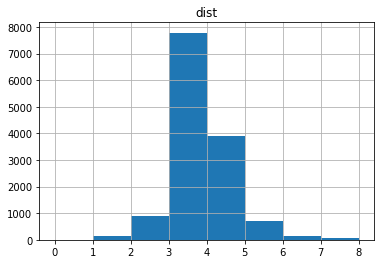

In [302]:
# plot distribution
votes_714.loc[votes_714['dist'] <= 10].hist('dist', bins=8)